In [4]:

import pandas as pd
import numpy as np

# Function to generate random geohashes (for simplicity, we'll use a fixed set)
def random_geohash():
    geohashes = ['u4pruydqqvj', 'u4xjjdfc9p0', 'u4xjqz0hhnt', 'u4pruyd7fvj']
    return np.random.choice(geohashes)

# Create a synthetic dataset
np.random.seed(42)  # For reproducibility
num_rows = 100
data = {
    'geohash': [random_geohash() for _ in range(num_rows)],
    'duration': np.random.randint(1, 1000, size=num_rows),
    'mesg_count': np.random.randint(1, 100, size=num_rows),
    'density_region': np.random.choice(['Dark', 'Light'], size=num_rows)
}

# Convert to DataFrame
df = pd.DataFrame(data)
df.head()


,geohash,duration,mesg_count,density_region
0,u4xjqz0hhnt,703,52,Light
1,u4pruyd7fvj,402,96,Dark
2,u4pruydqqvj,730,4,Light
3,u4xjqz0hhnt,556,94,Dark
4,u4xjqz0hhnt,162,23,Light


In [5]:
# Feature: Message density
df['message_density'] = df['mesg_count'] / df['duration']
df.head()

,geohash,duration,mesg_count,density_region,message_density
0,u4xjqz0hhnt,703,52,Light,0.073969
1,u4pruyd7fvj,402,96,Dark,0.238806
2,u4pruydqqvj,730,4,Light,0.005479
3,u4xjqz0hhnt,556,94,Dark,0.169065
4,u4xjqz0hhnt,162,23,Light,0.141975


In [6]:
# One-hot encoding for density_region
df = pd.get_dummies(df, columns=['density_region'], prefix='region')
df.head()

,geohash,duration,mesg_count,message_density,region_Dark,region_Light
0,u4xjqz0hhnt,703,52,0.073969,False,True
1,u4pruyd7fvj,402,96,0.238806,True,False
2,u4pruydqqvj,730,4,0.005479,False,True
3,u4xjqz0hhnt,556,94,0.169065,True,False
4,u4xjqz0hhnt,162,23,0.141975,False,True


In [7]:
# Feature: Duration categories
df['duration_category'] = pd.qcut(df['duration'], q=4, labels=['short', 'medium', 'long', 'very_long'])
df.head()

,geohash,duration,mesg_count,message_density,region_Dark,region_Light,duration_category
0,u4xjqz0hhnt,703,52,0.073969,False,True,long
1,u4pruyd7fvj,402,96,0.238806,True,False,medium
2,u4pruydqqvj,730,4,0.005479,False,True,long
3,u4xjqz0hhnt,556,94,0.169065,True,False,long
4,u4xjqz0hhnt,162,23,0.141975,False,True,short


In [8]:
# Aggregated features by geohash
agg_features = df.groupby('geohash').agg({
    'duration': ['mean', 'std'],
    'mesg_count': ['sum']
}).reset_index()

In [9]:
agg_features.head()

geohash    duration             mesg_count
                      mean         std        sum
0  u4pruyd7fvj  436.866667  281.882310       1545
1  u4pruydqqvj  495.450000  350.152820        958
2  u4xjjdfc9p0  626.461538  275.953218       1408
3  u4xjqz0hhnt  520.500000  249.620756       1183

In [10]:
agg_features.columns = ['geohash', 'mean_duration', 'std_duration', 'total_mesg_count']

# Merge aggregated features back
df = df.merge(agg_features, on='geohash', how='left')

In [11]:
df.head()

,geohash,duration,mesg_count,message_density,region_Dark,region_Light,duration_category,mean_duration,std_duration,total_mesg_count
0,u4xjqz0hhnt,703,52,0.073969,False,True,long,520.500000,249.620756,1183
1,u4pruyd7fvj,402,96,0.238806,True,False,medium,436.866667,281.882310,1545
2,u4pruydqqvj,730,4,0.005479,False,True,long,495.450000,350.152820,958
3,u4xjqz0hhnt,556,94,0.169065,True,False,long,520.500000,249.620756,1183
4,u4xjqz0hhnt,162,23,0.141975,False,True,short,520.500000,249.620756,1183


In [12]:
# Create new features
df['normalized_mesg_count'] = df['mesg_count'] / df['total_mesg_count']
df['weighted_duration'] = df['duration'] * df['message_density']
df['interaction_region'] = df['region_Dark'] & df['region_Light']  # Logical AND for interaction
df['duration_deviation'] = df['duration'] - df['mean_duration']

# Drop unwanted features
columns_to_drop = ['mean_duration', 'std_duration', 'total_mesg_count']
df_cleaned = df.drop(columns=columns_to_drop)



In [13]:
df.head()

,geohash,duration,mesg_count,message_density,region_Dark,region_Light,duration_category,mean_duration,std_duration,total_mesg_count,normalized_mesg_count,weighted_duration,interaction_region,duration_deviation
0,u4xjqz0hhnt,703,52,0.073969,False,True,long,520.500000,249.620756,1183,0.043956,52.0,False,182.500000
1,u4pruyd7fvj,402,96,0.238806,True,False,medium,436.866667,281.882310,1545,0.062136,96.0,False,-34.866667
2,u4pruydqqvj,730,4,0.005479,False,True,long,495.450000,350.152820,958,0.004175,4.0,False,234.550000
3,u4xjqz0hhnt,556,94,0.169065,True,False,long,520.500000,249.620756,1183,0.079459,94.0,False,35.500000
4,u4xjqz0hhnt,162,23,0.141975,False,True,short,520.500000,249.620756,1183,0.019442,23.0,False,-358.500000


In [14]:
# Create new features
df['density_category'] = pd.cut(
    df['message_density'],
    bins=[0, 0.05, 0.15, 1],
    labels=['low', 'medium', 'high']
)

df['region_interaction_score'] = (
    df['region_Dark'].astype(int) + df['region_Light'].astype(int)
)

df['relative_duration'] = df['duration'] / df['mean_duration']
df['duration_to_std_ratio'] = df['duration_deviation'] / df['std_duration']
df['message_density_weighted_mesg_count'] = df['mesg_count'] * df['message_density']

# Drop unwanted columns
columns_to_drop = ['mean_duration', 'std_duration', 'total_mesg_count', 'interaction_region']
df_cleaned = df.drop(columns=columns_to_drop)

df.head()


,geohash,duration,mesg_count,message_density,region_Dark,region_Light,duration_category,mean_duration,std_duration,total_mesg_count,normalized_mesg_count,weighted_duration,interaction_region,duration_deviation,density_category,region_interaction_score,relative_duration,duration_to_std_ratio,message_density_weighted_mesg_count
0,u4xjqz0hhnt,703,52,0.073969,False,True,long,520.500000,249.620756,1183,0.043956,52.0,False,182.500000,medium,1,1.350624,0.731109,3.846373
1,u4pruyd7fvj,402,96,0.238806,True,False,medium,436.866667,281.882310,1545,0.062136,96.0,False,-34.866667,high,1,0.920189,-0.123692,22.925373
2,u4pruydqqvj,730,4,0.005479,False,True,long,495.450000,350.152820,958,0.004175,4.0,False,234.550000,low,1,1.473408,0.669850,0.021918
3,u4xjqz0hhnt,556,94,0.169065,True,False,long,520.500000,249.620756,1183,0.079459,94.0,False,35.500000,high,1,1.068204,0.142216,15.892086
4,u4xjqz0hhnt,162,23,0.141975,False,True,short,520.500000,249.620756,1183,0.019442,23.0,False,-358.500000,medium,1,0.311239,-1.436179,3.265432


In [15]:
df_cleaned['region_interaction_score'].unique()

array([1])

In [16]:
# Define columns to keep
columns_to_keep = [
    'geohash', 'duration', 'mesg_count', 'message_density',
    'density_category', 'region_interaction_score',
    'duration_category', 'relative_duration',
    'duration_to_std_ratio', 'message_density_weighted_mesg_count'
]

# Filter the DataFrame
df = df[columns_to_keep]




In [17]:
df_cleaned.head()

,geohash,duration,mesg_count,message_density,region_Dark,region_Light,duration_category,normalized_mesg_count,weighted_duration,duration_deviation,density_category,region_interaction_score,relative_duration,duration_to_std_ratio,message_density_weighted_mesg_count
0,u4xjqz0hhnt,703,52,0.073969,False,True,long,0.043956,52.0,182.500000,medium,1,1.350624,0.731109,3.846373
1,u4pruyd7fvj,402,96,0.238806,True,False,medium,0.062136,96.0,-34.866667,high,1,0.920189,-0.123692,22.925373
2,u4pruydqqvj,730,4,0.005479,False,True,long,0.004175,4.0,234.550000,low,1,1.473408,0.669850,0.021918
3,u4xjqz0hhnt,556,94,0.169065,True,False,long,0.079459,94.0,35.500000,high,1,1.068204,0.142216,15.892086
4,u4xjqz0hhnt,162,23,0.141975,False,True,short,0.019442,23.0,-358.500000,medium,1,0.311239,-1.436179,3.265432


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [20]:
# Summary statistics
print(df.describe())


         duration  mesg_count  message_density  region_interaction_score  \
count  100.000000  100.000000       100.000000                     100.0   
mean   517.950000   50.940000         0.341087                       1.0   
std    292.746671   29.840255         1.171893                       0.0   
min      5.000000    1.000000         0.001462                       1.0   
25%    265.500000   27.750000         0.053559                       1.0   
50%    534.000000   54.500000         0.093865                       1.0   
75%    767.500000   73.500000         0.189993                       1.0   
max    996.000000   98.000000        11.200000                       1.0   

       relative_duration  duration_to_std_ratio  \
count         100.000000           1.000000e+02   
mean            1.000000           3.330669e-18   
std             0.565904           9.847319e-01   
min             0.010092          -2.215816e+00   
25%             0.516206          -8.552325e-01   
50%      

In [21]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   geohash                              100 non-null    object  
 1   duration                             100 non-null    int64   
 2   mesg_count                           100 non-null    int64   
 3   message_density                      100 non-null    float64 
 4   density_category                     92 non-null     category
 5   region_interaction_score             100 non-null    int64   
 6   duration_category                    100 non-null    category
 7   relative_duration                    100 non-null    float64 
 8   duration_to_std_ratio                100 non-null    float64 
 9   message_density_weighted_mesg_count  100 non-null    float64 
dtypes: category(2), float64(4), int64(3), object(1)
memory usage: 6.9+ KB
None


In [22]:
# Check for missing values
print(df.isnull().sum())


geohash                                0
duration                               0
mesg_count                             0
message_density                        0
density_category                       8
region_interaction_score               0
duration_category                      0
relative_duration                      0
duration_to_std_ratio                  0
message_density_weighted_mesg_count    0
dtype: int64


In [23]:
# Check for duplicates
print(df.duplicated().sum())

0


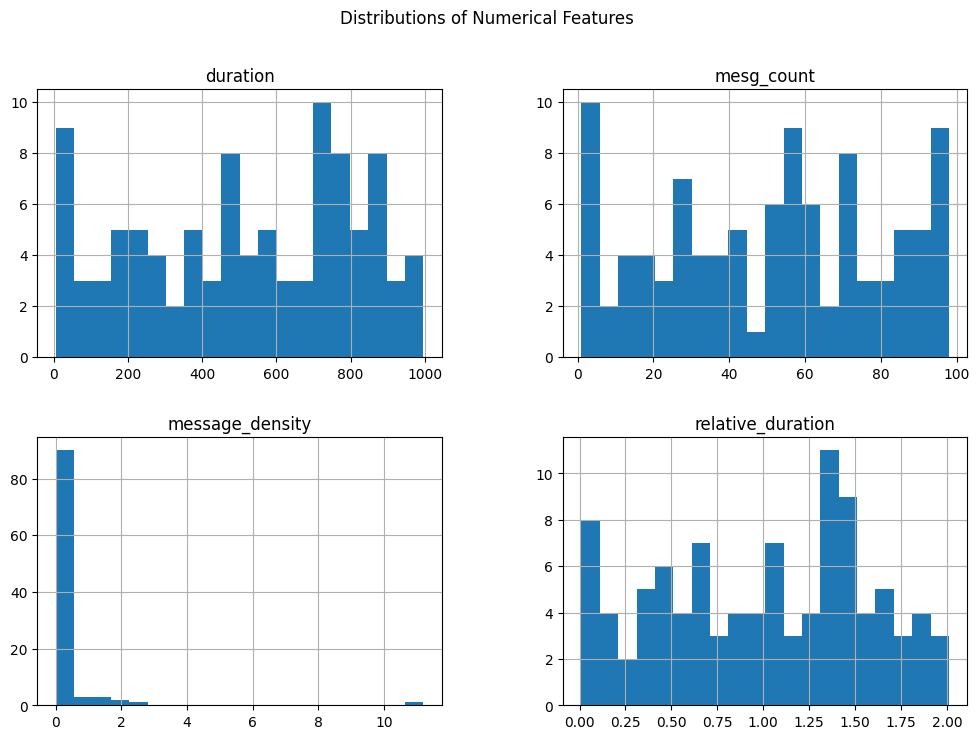

In [24]:
# Plot histograms
numerical_columns = ['duration', 'mesg_count', 'message_density', 'relative_duration']
df[numerical_columns].hist(bins=20, figsize=(12, 8), layout=(2, 2))
plt.suptitle("Distributions of Numerical Features")
plt.show()

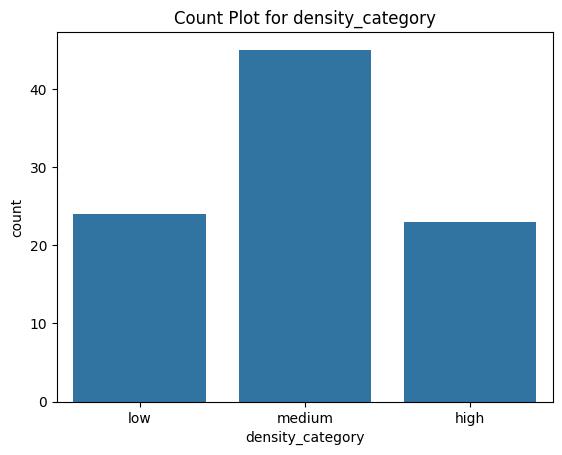

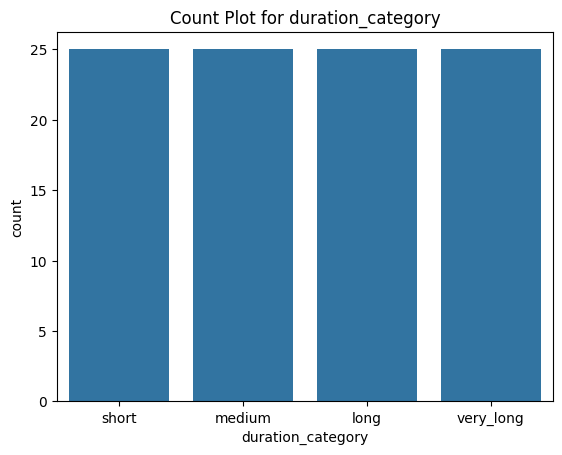

In [25]:
# Count plots for categorical columns
categorical_columns = ['density_category', 'duration_category']
for col in categorical_columns:
    sns.countplot(x=col, data=df)
    plt.title(f"Count Plot for {col}")
    plt.show()


In [ ]:
# Heatmap for correlation
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()


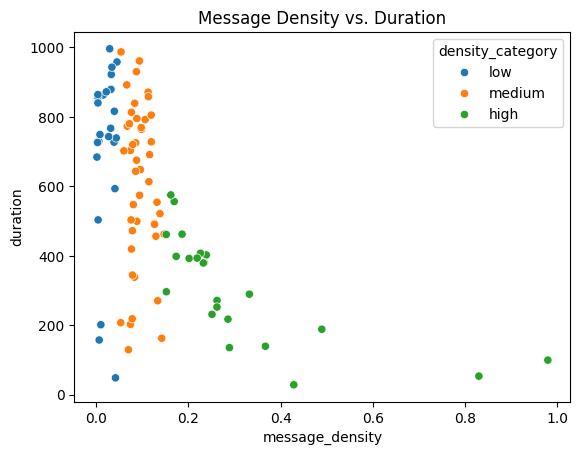

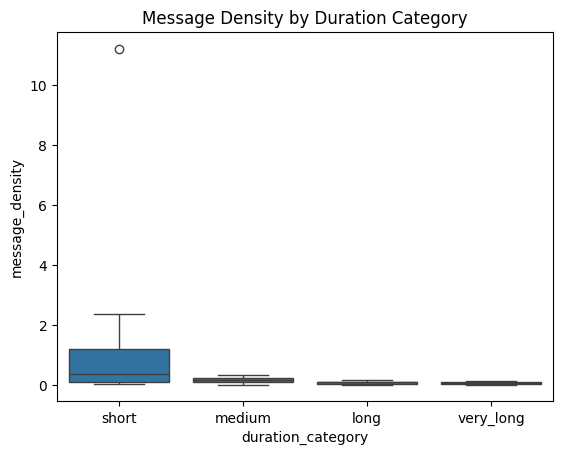

In [27]:
# Scatter plot: Message density vs. Duration
sns.scatterplot(data=df, x='message_density', y='duration', hue='density_category')
plt.title("Message Density vs. Duration")
plt.show()

# Boxplot: Message density grouped by Duration Category
sns.boxplot(data=df, x='duration_category', y='message_density')
plt.title("Message Density by Duration Category")
plt.show()


<ipython-input-28-140a3a93f63b>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='density_category', y='region_interaction_score', ci=None)


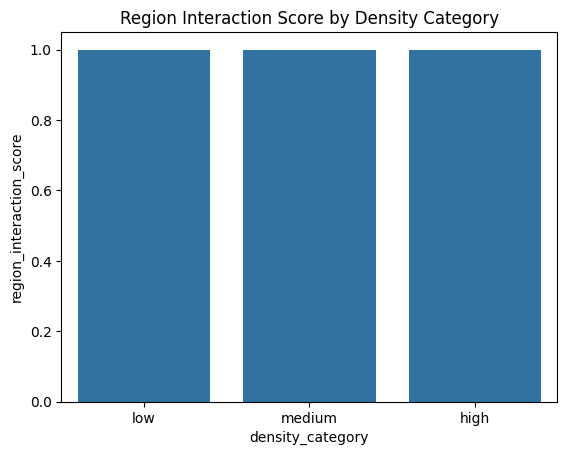

In [28]:
# Bar plot: Region Interaction Score by Density Category
sns.barplot(data=df, x='density_category', y='region_interaction_score', ci=None)
plt.title("Region Interaction Score by Density Category")
plt.show()

### 1. General Analysis
Message Patterns


Top Geohashes by Message Density:
 geohash
u4pruydqqvj    0.899311
u4pruyd7fvj    0.274680
u4xjjdfc9p0    0.198949
u4xjqz0hhnt    0.112891
Name: message_density, dtype: float64
Bottom Geohashes by Message Density:
 geohash
u4xjqz0hhnt    0.112891
u4xjjdfc9p0    0.198949
u4pruyd7fvj    0.274680
u4pruydqqvj    0.899311
Name: message_density, dtype: float64


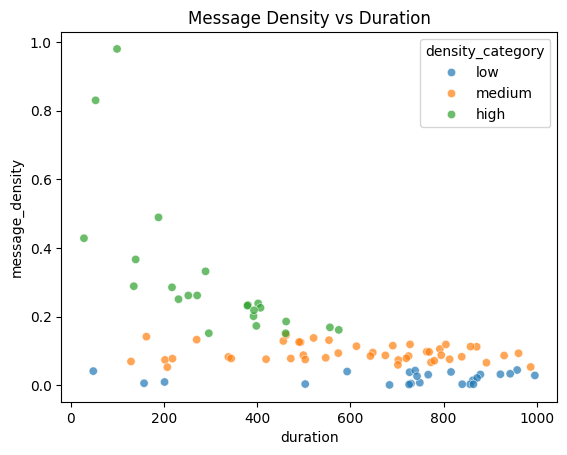

In [41]:
# Top and bottom geohash regions by message density
top_geohashes = df.groupby('geohash')['message_density'].mean().sort_values(ascending=False).head(5)
bottom_geohashes = df.groupby('geohash')['message_density'].mean().sort_values(ascending=True).head(5)

print("Top Geohashes by Message Density:\n", top_geohashes)
print("Bottom Geohashes by Message Density:\n", bottom_geohashes)

# Scatter plot: message_density vs duration
sns.scatterplot(data=df, x='duration', y='message_density', hue='density_category', alpha=0.7)
plt.title("Message Density vs Duration")
plt.show()


### 2. Duration Insights
Variations Across Geohash Regions

<ipython-input-42-f04156834b99>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='geohash', y='relative_duration', palette='viridis')


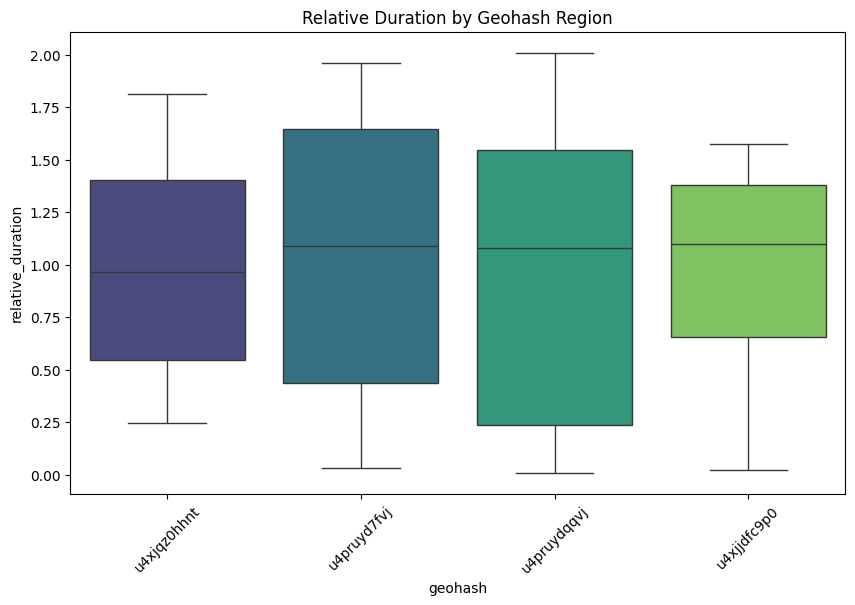

In [42]:
# Boxplot: relative_duration by geohash
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='geohash', y='relative_duration', palette='viridis')
plt.title("Relative Duration by Geohash Region")
plt.xticks(rotation=45)
plt.show()


### Patterns in Dark vs Light Regions

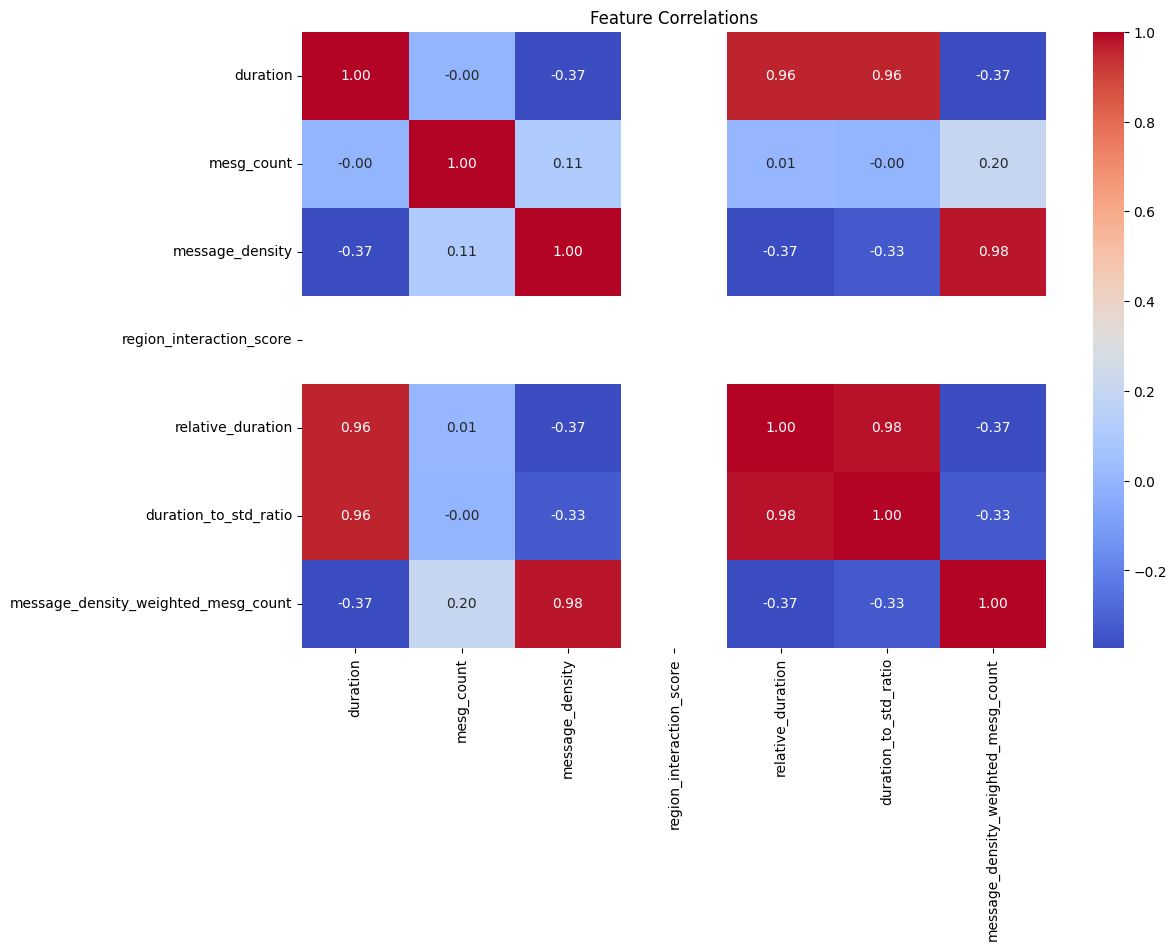

In [57]:
# Exclude non-numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Feature Correlations")
plt.show()


### 3. Categorical Trends
Impact of Categories on Interaction Score

<ipython-input-44-7fca96e07829>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='density_category', y='region_interaction_score', palette='muted')


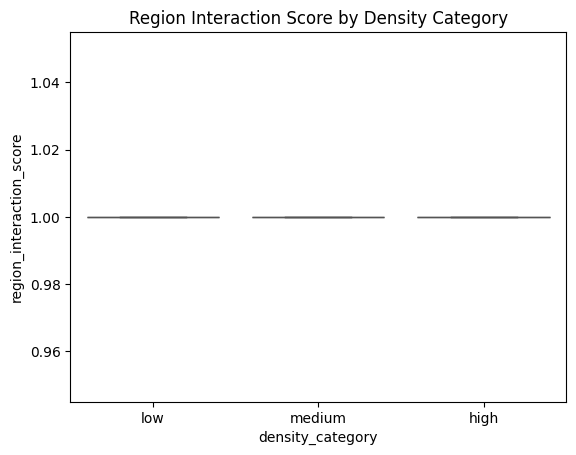

<ipython-input-44-7fca96e07829>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='duration_category', y='region_interaction_score', palette='coolwarm')


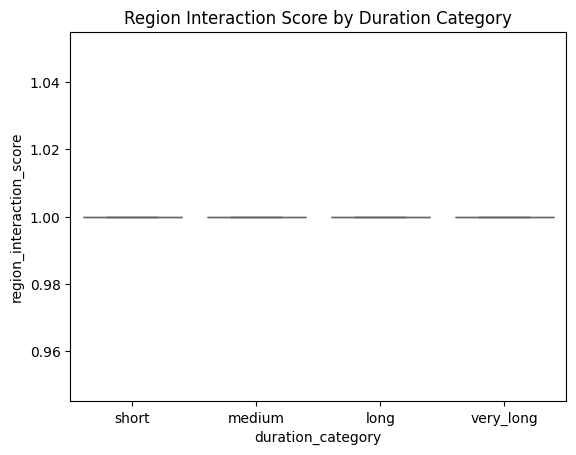

In [44]:
# Boxplot: region_interaction_score by density_category
sns.boxplot(data=df, x='density_category', y='region_interaction_score', palette='muted')
plt.title("Region Interaction Score by Density Category")
plt.show()

# Boxplot: region_interaction_score by duration_category
sns.boxplot(data=df, x='duration_category', y='region_interaction_score', palette='coolwarm')
plt.title("Region Interaction Score by Duration Category")
plt.show()


### 4. Correlation and Relationships
Feature Correlations

In [65]:
# Heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Feature Correlations")
plt.show()

# Relationship: region_interaction_score vs relative_duration
sns.scatterplot(data=df, x='relative_duration', y='region_interaction_score', hue='density_category')
plt.title("Region Interaction Score vs Relative Duration")
plt.show()


ValueError: could not convert string to float: 'u4xjqz0hhnt'

<Figure size 1200x800 with 0 Axes>

### 5. Region-Specific Trends
High/Low Interaction Score Regions

In [46]:
# Top and bottom geohash regions by region_interaction_score
top_interaction_regions = df.groupby('geohash')['region_interaction_score'].mean().sort_values(ascending=False).head(5)
low_interaction_regions = df.groupby('geohash')['region_interaction_score'].mean().sort_values().head(5)

print("Top Geohash Regions by Interaction Score:\n", top_interaction_regions)
print("Low Geohash Regions by Interaction Score:\n", low_interaction_regions)


Top Geohash Regions by Interaction Score:
 geohash
u4pruyd7fvj    1.0
u4pruydqqvj    1.0
u4xjjdfc9p0    1.0
u4xjqz0hhnt    1.0
Name: region_interaction_score, dtype: float64
Low Geohash Regions by Interaction Score:
 geohash
u4pruyd7fvj    1.0
u4pruydqqvj    1.0
u4xjjdfc9p0    1.0
u4xjqz0hhnt    1.0
Name: region_interaction_score, dtype: float64


### 6. Impact Analysis
Weighted Features

In [55]:
df.head()

,geohash,duration,mesg_count,message_density,density_category,region_interaction_score,duration_category,relative_duration,duration_to_std_ratio,message_density_weighted_mesg_count,cluster
0,u4xjqz0hhnt,703,52,0.073969,medium,1,long,1.350624,0.731109,3.846373,0
1,u4pruyd7fvj,402,96,0.238806,high,1,medium,0.920189,-0.123692,22.925373,1
2,u4pruydqqvj,730,4,0.005479,low,1,long,1.473408,0.669850,0.021918,0
3,u4xjqz0hhnt,556,94,0.169065,high,1,long,1.068204,0.142216,15.892086,0
4,u4xjqz0hhnt,162,23,0.141975,medium,1,short,0.311239,-1.436179,3.265432,1


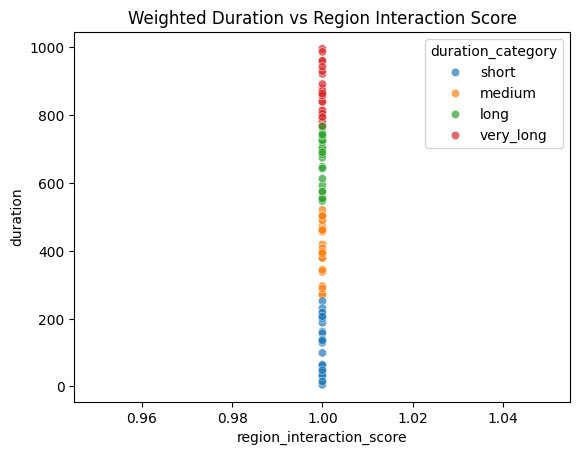

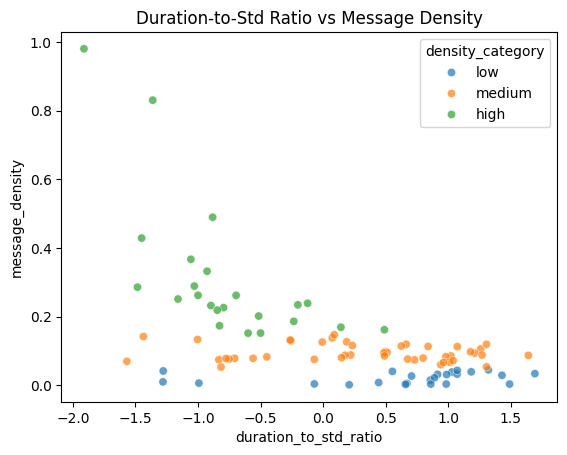

In [56]:

sns.scatterplot(data=df, x='region_interaction_score', y='duration', hue='duration_category', alpha=0.7)
plt.title("Weighted Duration vs Region Interaction Score")
plt.show()

sns.scatterplot(data=df, x='duration_to_std_ratio', y='message_density', hue='density_category', alpha=0.7)
plt.title("Duration-to-Std Ratio vs Message Density")
plt.show()


### Category-Specific Insights

<ipython-input-48-432a6bc183f3>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='duration_category', y='message_density_weighted_mesg_count', ci=None, palette='Blues_d')
<ipython-input-48-432a6bc183f3>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='duration_category', y='message_density_weighted_mesg_count', ci=None, palette='Blues_d')


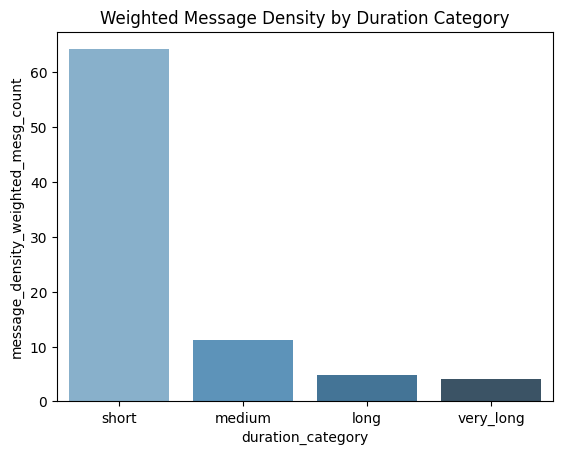

In [48]:
# Barplot: message_density_weighted_mesg_count by duration_category
sns.barplot(data=df, x='duration_category', y='message_density_weighted_mesg_count', ci=None, palette='Blues_d')
plt.title("Weighted Message Density by Duration Category")
plt.show()


### 7. Geohash-Level Analysis
Performance Trends

In [50]:
# Combined performance score for geohash regions
geohash_performance = df.groupby('geohash')[['message_density', 'region_interaction_score']].mean()
geohash_performance['combined_score'] = geohash_performance.sum(axis=1)

# Top and bottom-performing geohashes
top_performers = geohash_performance.sort_values('combined_score', ascending=False).head(5)
bottom_performers = geohash_performance.sort_values('combined_score').head(5)

print("Top Performing Geohash Regions:\n", top_performers)
print("Bottom Performing Geohash Regions:\n", bottom_performers)


Top Performing Geohash Regions:
              message_density  region_interaction_score  combined_score
geohash                                                               
u4pruydqqvj         0.899311                       1.0        1.899311
u4pruyd7fvj         0.274680                       1.0        1.274680
u4xjjdfc9p0         0.198949                       1.0        1.198949
u4xjqz0hhnt         0.112891                       1.0        1.112891
Bottom Performing Geohash Regions:
              message_density  region_interaction_score  combined_score
geohash                                                               
u4xjqz0hhnt         0.112891                       1.0        1.112891
u4xjjdfc9p0         0.198949                       1.0        1.198949
u4pruyd7fvj         0.274680                       1.0        1.274680
u4pruydqqvj         0.899311                       1.0        1.899311


### 8. Clustering Insights
KMeans Clustering

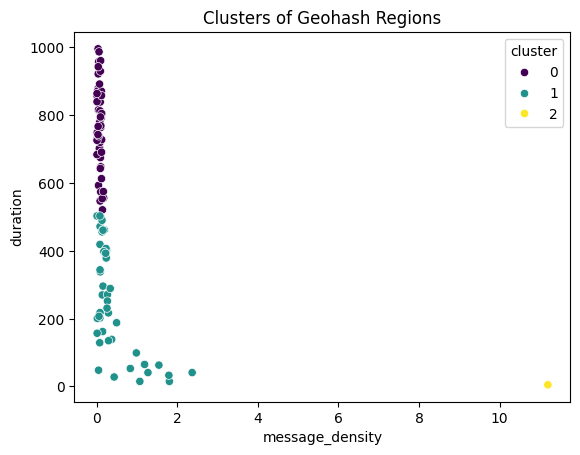

In [52]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Scaling features
clustering_features = df[['duration', 'message_density', 'region_interaction_score']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_features)

# Visualize clusters
sns.scatterplot(data=df, x='message_density', y='duration', hue='cluster', palette='viridis')
plt.title("Clusters of Geohash Regions")
plt.show()


In [58]:
df.head()

,geohash,duration,mesg_count,message_density,density_category,region_interaction_score,duration_category,relative_duration,duration_to_std_ratio,message_density_weighted_mesg_count,cluster
0,u4xjqz0hhnt,703,52,0.073969,medium,1,long,1.350624,0.731109,3.846373,0
1,u4pruyd7fvj,402,96,0.238806,high,1,medium,0.920189,-0.123692,22.925373,1
2,u4pruydqqvj,730,4,0.005479,low,1,long,1.473408,0.669850,0.021918,0
3,u4xjqz0hhnt,556,94,0.169065,high,1,long,1.068204,0.142216,15.892086,0
4,u4xjqz0hhnt,162,23,0.141975,medium,1,short,0.311239,-1.436179,3.265432,1


In [59]:
# Create impactful features
df['message_density_per_cluster'] = df.groupby('cluster')['message_density'].transform('mean')
df['normalized_duration'] = df['duration'] / df.groupby('cluster')['duration'].transform('mean')
df['duration_to_message_ratio'] = df['duration'] / df['mesg_count']
df['interaction_weighted_density'] = df['region_interaction_score'] * df['message_density']
df['relative_weighted_duration'] = df['relative_duration'] * df['message_density_weighted_mesg_count']

# One-hot encode or label encode categorical features if needed
# Example: Encoding cluster
df['cluster'] = df['cluster'].astype('category').cat.codes

In [60]:
df.head()

,geohash,duration,mesg_count,message_density,density_category,region_interaction_score,duration_category,relative_duration,duration_to_std_ratio,message_density_weighted_mesg_count,cluster,message_density_per_cluster,normalized_duration,duration_to_message_ratio,interaction_weighted_density,relative_weighted_duration
0,u4xjqz0hhnt,703,52,0.073969,medium,1,long,1.350624,0.731109,3.846373,0,0.068294,0.917614,13.519231,0.073969,5.195005
1,u4pruyd7fvj,402,96,0.238806,high,1,medium,0.920189,-0.123692,22.925373,1,0.404701,1.517220,4.187500,0.238806,21.095681
2,u4pruydqqvj,730,4,0.005479,low,1,long,1.473408,0.669850,0.021918,0,0.068294,0.952856,182.500000,0.005479,0.032294
3,u4xjqz0hhnt,556,94,0.169065,high,1,long,1.068204,0.142216,15.892086,0,0.068294,0.725737,5.914894,0.169065,16.975985
4,u4xjqz0hhnt,162,23,0.141975,medium,1,short,0.311239,-1.436179,3.265432,1,0.404701,0.611417,7.043478,0.141975,1.016330


In [62]:
# Retain important features including geohash for model input
columns_to_keep = [
    "geohash",  # Key feature for predictions
    "duration",
    "mesg_count",
    "message_density",
    "region_interaction_score",
    "relative_duration",
    "duration_to_std_ratio",
    "message_density_per_cluster",
    "normalized_duration",
    "duration_to_message_ratio",
    "interaction_weighted_density",
    "relative_weighted_duration",
    "density_category"
]

# Filter the dataset
df_cleaned = df[columns_to_keep]

df_cleaned.head()


,geohash,duration,mesg_count,message_density,region_interaction_score,relative_duration,duration_to_std_ratio,message_density_per_cluster,normalized_duration,duration_to_message_ratio,interaction_weighted_density,relative_weighted_duration,density_category
0,u4xjqz0hhnt,703,52,0.073969,1,1.350624,0.731109,0.068294,0.917614,13.519231,0.073969,5.195005,medium
1,u4pruyd7fvj,402,96,0.238806,1,0.920189,-0.123692,0.404701,1.517220,4.187500,0.238806,21.095681,high
2,u4pruydqqvj,730,4,0.005479,1,1.473408,0.669850,0.068294,0.952856,182.500000,0.005479,0.032294,low
3,u4xjqz0hhnt,556,94,0.169065,1,1.068204,0.142216,0.068294,0.725737,5.914894,0.169065,16.975985,high
4,u4xjqz0hhnt,162,23,0.141975,1,0.311239,-1.436179,0.404701,0.611417,7.043478,0.141975,1.016330,medium


(100, 12)
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - accuracy: 0.2461 - loss: 0.9410 - val_accuracy: 0.0000e+00 - val_loss: 0.6950
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1914 - loss: 1.0154 - val_accuracy: 0.1500 - val_loss: 0.5775
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1742 - loss: 0.8036 - val_accuracy: 0.2000 - val_loss: 0.5166
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3367 - loss: 0.5180 - val_accuracy: 0.2000 - val_loss: 0.4837
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3055 - loss: 0.5303 - val_accuracy: 0.2000 - val_loss: 0.4664
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2773 - loss: 0.6027 - val_accuracy: 0.2000 - val_loss: 0.4508
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3102 - loss: 0.4796 - val_accuracy: 0.2000 - val_loss: 0.4414
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3250 - loss: 0.1647 - val_accuracy: 0.2000 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


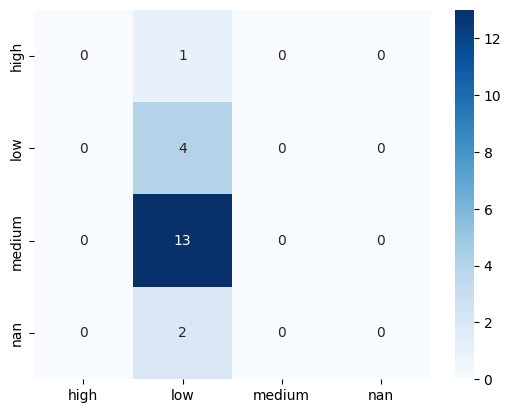

In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Function to scale features
def scale_features(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler

# Function to split the data into training and testing sets
def split_data(X_scaled, y):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

# Function to build a more complex neural network model with embedding for Geohash
def build_complex_model(input_dim, num_geohashes, embedding_dim=10):
    # Geohash input for embedding
    geohash_input = Input(shape=(1,), dtype='int32', name='Geohash_Encoded')

    # Embedding layer for geohash
    geohash_embedding = Embedding(input_dim=num_geohashes, output_dim=embedding_dim)(geohash_input)
    geohash_embedding_flat = Flatten()(geohash_embedding)  # Flatten the embedding output

    # Input for other features (Message Count, Density Value)
    other_features_input = Input(shape=(input_dim,), dtype='float32', name='Other_Features')

    # Concatenate the geohash embedding with the other features
    concatenated = tf.keras.layers.concatenate([geohash_embedding_flat, other_features_input])

    # Build the model
    dense_1 = Dense(128, activation='relu')(concatenated)
    dense_1 = BatchNormalization()(dense_1)
    dense_1 = Dropout(0.5)(dense_1)

    dense_2 = Dense(128, activation='relu')(dense_1)
    dense_2 = BatchNormalization()(dense_2)

    dense_3 = Dense(128, activation='relu')(dense_2)
    dense_3 = BatchNormalization()(dense_3)
    dense_3 = Dropout(0.5)(dense_3)

    dense_4 = Dense(64, activation='relu')(dense_3)
    dense_4 = BatchNormalization()(dense_4)

    dense_5 = Dense(64, activation='relu')(dense_4)
    dense_5 = BatchNormalization()(dense_5)

    dense_6 = Dense(32, activation='relu')(dense_5)
    dense_6 = BatchNormalization()(dense_6)

    # Output layer: Sigmoid for binary classification
    output = Dense(1, activation='sigmoid')(dense_6)

    # Create the model
    model = Model(inputs=[geohash_input, other_features_input], outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Assuming df is already loaded and processed
geohash_encoder = LabelEncoder()
df['Geohash_Encoded'] = geohash_encoder.fit_transform(df['geohash'])

density_encoder = LabelEncoder()
df['Density_Label'] = density_encoder.fit_transform(df['density_category'])

# Ensure the correct features are selected based on your dataset
X = df[[
    "Geohash_Encoded",  # Geohash feature
    "duration",
    "mesg_count",
    "message_density",
    "region_interaction_score",
    "relative_duration",
    "duration_to_std_ratio",
    "message_density_per_cluster",
    "normalized_duration",
    "duration_to_message_ratio",
    "interaction_weighted_density",
    "relative_weighted_duration"]]  # 12 features

y = df["Density_Label"]

# Check the shape of X to ensure it matches the expected number of features
print(X.shape)  # Should print (n_samples, 12)

# Scale the features
X_scaled, scaler = scale_features(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = split_data(X_scaled, y)

# Number of unique geohash categories
num_geohashes = len(df['Geohash_Encoded'].unique())

# Build the model
model = build_complex_model(input_dim=X_train.shape[1] - 1, num_geohashes=num_geohashes, embedding_dim=10)

# Prepare inputs for training
geohash_train = X_train[:, 0].reshape(-1, 1)  # Geohash_Encoded column as separate input
other_features_train = X_train[:, 1:]  # All other features (11 features)

geohash_test = X_test[:, 0].reshape(-1, 1)  # Geohash_Encoded column as separate input
other_features_test = X_test[:, 1:]  # All other features (11 features)

# Train the model
model.fit([geohash_train, other_features_train], y_train, epochs=10, batch_size=32, validation_data=([geohash_test, other_features_test], y_test))

# Evaluate the model
y_pred = model.predict([geohash_test, other_features_test])
y_pred = (y_pred > 0.5).astype(int)

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Optionally: Visualize confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=density_encoder.classes_, yticklabels=density_encoder.classes_)
plt.show()


(100, 4)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.2430 - loss: 0.6136 - val_accuracy: 0.2000 - val_loss: 0.6611
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2805 - loss: 0.7974 - val_accuracy: 0.2000 - val_loss: 0.6584
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2078 - loss: 0.7524 - val_accuracy: 0.2000 - val_loss: 0.6562
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3703 - loss: 0.7834 - val_accuracy: 0.2000 - val_loss: 0.6319
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3023 - loss: 0.3440 - val_accuracy: 0.2000 - val_loss: 0.6035
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2945 - loss: 0.2257 - val_accuracy: 0.2000 - val_loss: 0.5756
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2883 - loss: 0.5577 - val_accuracy: 0.2000 - val_loss: 0.5497
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3328 - loss: 0.5610 - val_accuracy: 0.2000 - val_loss: 0.5191

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Set Accuracy with Neural Network: 0.25
Classification Report with Neural Network:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.21      1.00      0.35         4
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         2

    accuracy                           0.25        20
   macro avg       0.30      0.50      0.34        20
weighted avg       0.09      0.25      0.12        20



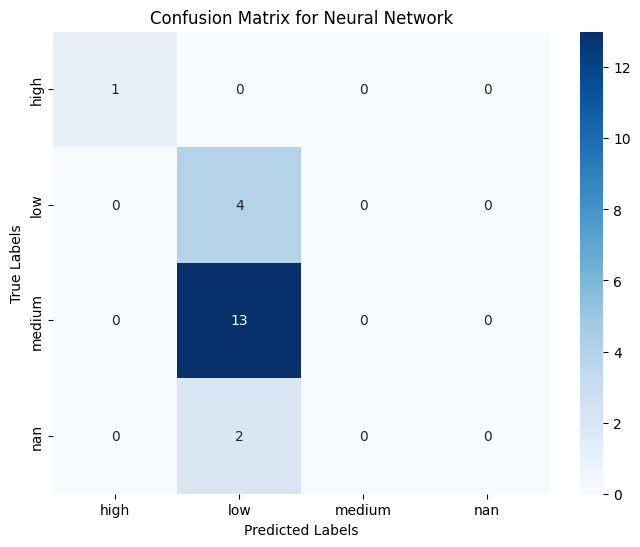

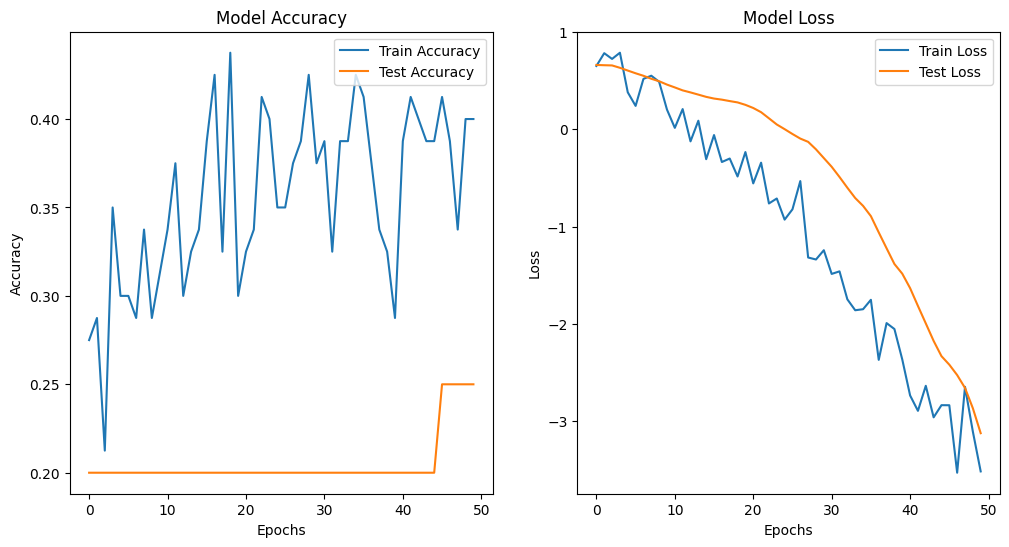

Model has been saved to complex_nn_model.h5 successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Set Accuracy with Loaded Model: 0.25
Classification Report with Loaded Model:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.21      1.00      0.35         4
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         2

    accuracy                           0.25        20
   macro avg       0.30      0.50      0.34        20
weighted avg       0.09      0.25      0.12        20



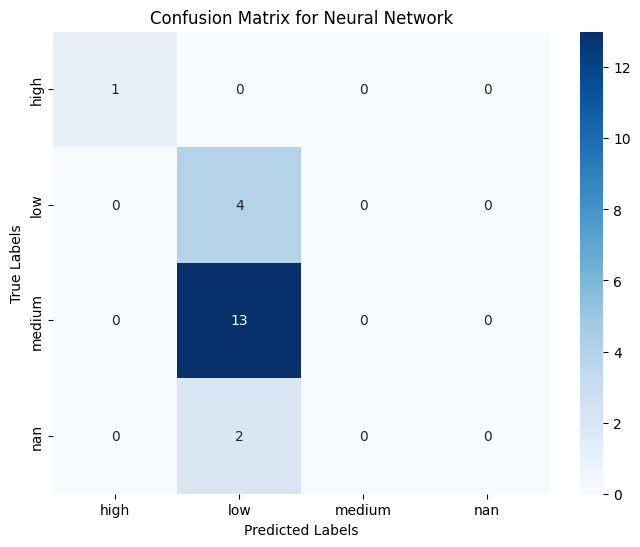

In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
# Function to build a more complex neural network model
def build_complex_model(input_dim):
    model = Sequential()

    # Input layer: input_dim should match the number of features
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())  # Batch normalization for stable training
    model.add(Dropout(0.5))  # Dropout layer to prevent overfitting

    # Hidden layer 1
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())  # Batch normalization

    # Hidden layer 2
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())  # Batch normalization
    model.add(Dropout(0.5))  # Dropout to prevent overfitting

    # Hidden layer 3
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())  # Batch normalization

    # Hidden layer 4
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())  # Batch normalization

    # Hidden layer 5
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())  # Batch normalization

    # Output layer: Sigmoid for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Function to train the model
def train_model(model, X_train, y_train, X_test, y_test):
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
    return history

# Function to evaluate the model
def evaluate_model(model, X_test, y_test, density_encoder):
    y_pred_nn = (model.predict(X_test) > 0.5).astype("int32")
    accuracy_nn = accuracy_score(y_test, y_pred_nn)
    report_nn = classification_report(y_test, y_pred_nn)

    print("Test Set Accuracy with Neural Network:", accuracy_nn)
    print("Classification Report with Neural Network:\n", report_nn)

    cm_nn = confusion_matrix(y_test, y_pred_nn)
    plot_confusion_matrix(cm_nn, density_encoder.classes_)

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, class_labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Neural Network')
    plt.show()

# Function to plot accuracy and loss curves
def plot_accuracy_loss(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Function to save the trained model
def save_model(model, model_path):
    model.save(model_path)
    print(f"Model has been saved to {model_path} successfully!")

# Function to load the model for predictions
def load_trained_model(model_path):
    return load_model(model_path)

# Function to use the loaded model for predictions
def predict_with_loaded_model(loaded_model, X_test):
    y_pred_loaded = (loaded_model.predict(X_test) > 0.5).astype("int32")
    return y_pred_loaded

# Function to evaluate the loaded model
def evaluate_loaded_model(loaded_model, X_test, y_test, density_encoder):
    y_pred_loaded = predict_with_loaded_model(loaded_model, X_test)
    accuracy_loaded = accuracy_score(y_test, y_pred_loaded)
    report_loaded = classification_report(y_test, y_pred_loaded)

    print("Test Set Accuracy with Loaded Model:", accuracy_loaded)
    print("Classification Report with Loaded Model:\n", report_loaded)

    cm_loaded = confusion_matrix(y_test, y_pred_loaded)
    plot_confusion_matrix(cm_loaded, density_encoder.classes_)



X = df[[
    "Geohash_Encoded",  # Geohash feature
    "duration",
    "mesg_count",
    "message_density"]]

y = df["Density_Label"]

# Check the shape of X to ensure it matches the expected number of features
print(X.shape)  # Should print (n_samples, 12)

# Scale the features
X_scaled, scaler = scale_features(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = split_data(X_scaled, y)

# Step 6: Build the more complex neural network model
model = build_complex_model(input_dim=X_train.shape[1])

# Step 7: Train the model
history = train_model(model, X_train, y_train, X_test, y_test)

# Step 8: Evaluate the model
evaluate_model(model, X_test, y_test, density_encoder)

# Step 9: Plot accuracy and loss curves
plot_accuracy_loss(history)

# Step 10: Save the model
save_model(model, 'complex_nn_model.h5')

# Step 11: Load the trained model for predictions
loaded_model = load_trained_model('complex_nn_model.h5')

# Step 12: Evaluate the loaded model
evaluate_loaded_model(loaded_model, X_test, y_test, density_encoder)

